Tutorial <b><a href="https://">Learn, Denoise and Discover: A Guide to Deep Denoising with an Application to Electron Microscopy</a> </b> (<a href="https://kangningthu.github.io/AI-powered-denoising">Website</a>)

This notebook illustrates the effect of two different design choices (the presence of a skip connection and the number of layers in the network) on a neural network that denoises 1D piecewise-constant signals corrupted by additive Gaussian noise.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data as udata
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Generation of 1D piecewise constant signals
class PieceWiseConstantDataset(udata.Dataset):

    def __init__(self, n_data = 1000, n_signal = 40, prob=0.3, fix_datapoints = True,
                  min_val = 0, max_val = 1, min_sep = 20, min_diff=0.4, use_circular_shift=True, circular_shift_get_item= False, seed=0, shift_item = False):
        super(PieceWiseConstantDataset, self).__init__()

        assert(min_sep > 0)
        self.n_data = n_data;
        self.n_signal = n_signal;
        self.prob = prob
        self.fix_datapoints = fix_datapoints;
        self.min_val = min_val;
        self.max_val = max_val;
        self.min_sep = min_sep;
        self.min_diff = min_diff
        assert min_diff < (max_val-min_val)/2

        self.use_circular_shift = use_circular_shift
        self.circular_shift_get_item = circular_shift_get_item
        self.shift_item =shift_item

        np.random.seed(seed)

        if self.fix_datapoints:
            self.data_list = [None] * self.n_data;
            for i in range(self.n_data):
                # self.data_list[i] = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
                self.data_list[i] = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

    def __len__(self):
        return self.n_data

    def circular_shift_shift(self, signal, shift):
        return np.roll(signal, shift)

    def circular_shift(self, signal, shift):
        if shift > int(self.n_signal/2):
          return np.flip(signal).copy()
        else:
          return signal


    def gen_piecewise_constant(self, n, prob, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        min_diff = self.min_diff
        signal = np.zeros(n)
        val = np.random.uniform(min_val, max_val);
        ind = np.random.randint(n)
        for i in range(n):
            signal[ind] = val
            if np.random.rand() < prob:

                new_val = np.random.uniform(min_val, max_val)
                # Ensure the new value differs from the old value by at least min_diff
                while abs(new_val - val) < min_diff:
                    new_val = np.random.uniform(min_val, max_val)
                val = new_val
                # val = np.random.uniform(min_val, max_val);
            ind = np.mod(ind + 1,n)
        return signal

    def gen_piecewise_constant_minsep(self, n, prob, minsep, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        signal = np.zeros(n)
        ind = 0
        val = np.random.uniform(min_val, max_val);
        while ind < n:
            if ind + minsep > n:
                signal[ind:] = val
                break
            if ind == 0 or np.random.rand() < prob:
                val = np.random.uniform(min_val, max_val);
                sep = np.random.randint(1, minsep+1) if ind == 0 else minsep;
                if ind + sep > n:
                    signal[ind:] = val
                    break
                else:
                    signal[ind:(ind+sep)] = val
                    ind += sep
            else:
                signal[ind] = val
                ind += 1
        if self.use_circular_shift:
          shift = np.random.randint(n)
          # print(signal)
          signal = self.circular_shift(signal, shift)
        return signal

    def __getitem__(self, index):

        if self.fix_datapoints:
            signal = self.data_list[index];
        else:
            # signal = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
            signal = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

        if self.circular_shift_get_item:
          shift = np.random.randint(self.n_signal)
          if not self.shift_item:
            signal = self.circular_shift(signal, shift)
          else:
            signal = self.circular_shift_shift(signal, shift)



        return torch.from_numpy(signal).unsqueeze(0).type(torch.FloatTensor)

In [ ]:
# Generation of noise
def get_noise(signal, noise_std=0.1, noise_scale=1, max_noise=1,  mode='G'):
    if mode == 'poisson':
        scaled_signal = signal * noise_scale
        noise_sample = torch.tensor(np.random.poisson(scaled_signal.numpy()))
        noise = (noise_sample - scaled_signal) / noise_scale
    else:
        noise = torch.normal(0, noise_std, size=signal.shape)

    noise = torch.clamp(noise, -max_noise, max_noise)
    return noise


In [ ]:
# Evaluation of denoising error
def evaluate_error(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction='mean');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += 1;

    return error_val/total_length

In [ ]:
# Train network with continuous noise sampling
def train_network(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = evaluate_error(model, train_loader, noise_std)
        val_loss[epoch] =  evaluate_error(model, val_loader, noise_std)

        if epoch % 10 == 0:
            print(epoch, 'train error: ', train_loss[epoch],'validation error: ',val_loss[epoch])

    return train_loss, val_loss

In [ ]:
# 1D denoising convolutional neural network without a skip connection
class CNN(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True):
		super(CNN, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias = use_bias

		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			out = F.relu(out)

		out = self.last_layer(out);

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)

In [ ]:
# 1D convolutional neural network with skip connection
class CNNskipcon(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True, non_linear=True):
		super(CNNskipcon, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias= use_bias
		self.non_linear = non_linear


		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		if self.non_linear:
			out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			if self.non_linear:
				out = F.relu(out)

		out = self.last_layer(out) + x;

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)

In [ ]:
# Generate training and validation datasets
prob_val = 0.3
min_sep = 5
signal_length = 100
n_small = 10
n_large = 500
train_dataset_small = PieceWiseConstantDataset(n_data = n_small, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
train_dataset_large = PieceWiseConstantDataset(n_data = n_large, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader_small = DataLoader(dataset=train_dataset_small,
                          num_workers=0,
                          batch_size=5, shuffle=True);
train_loader_large = DataLoader(dataset=train_dataset_large,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
noise_std = 0.1

In [ ]:
# Train network without skip connection on small dataset
nn_wo_skip_small = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_wo_skip_small, val_loss_wo_skip_small = train_network(nn_wo_skip_small, train_loader_small, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.22398778051137924 validation error:  0.2372804555296898
10 train error:  0.021458557806909084 validation error:  0.020889521958306432
20 train error:  0.011622258927673101 validation error:  0.01131673111114651
30 train error:  0.005754880839958787 validation error:  0.0060625841515138746
40 train error:  0.004101189086213708 validation error:  0.004190140382852405
50 train error:  0.003613119013607502 validation error:  0.0036400686926208437
60 train error:  0.003179845749400556 validation error:  0.003447993192821741
70 train error:  0.0027161360485479236 validation error:  0.003344295785063878
80 train error:  0.0026775322621688247 validation error:  0.0033804745250381528
90 train error:  0.0032894659088924527 validation error:  0.003391093829413876


In [ ]:
# Train network without skip connection on large dataset
nn_wo_skip_large = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_wo_skip_large, val_loss_wo_skip_large = train_network(nn_wo_skip_large, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.03541111503727734 validation error:  0.03544834587723017
10 train error:  0.0027119052538182586 validation error:  0.0029211412067525087
20 train error:  0.0024792725016595796 validation error:  0.0024548939662054183
30 train error:  0.0024024654703680426 validation error:  0.002385716901626438
40 train error:  0.0023740910837659612 validation error:  0.0024770750163588674
50 train error:  0.0023057581420289353 validation error:  0.002242950820364058
60 train error:  0.002291405704454519 validation error:  0.002237883900525048
70 train error:  0.002337918835110031 validation error:  0.0022565123025560753
80 train error:  0.002297183127666358 validation error:  0.002382798175094649
90 train error:  0.0022995003237156197 validation error:  0.0022359099122695623


In [ ]:
# Train network with skip connection on small dataset
nn_skip_small = CNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_skip_small, val_loss_skip_small = train_network(nn_skip_small, train_loader_small, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.00954112084582448 validation error:  0.009748760270886123
10 train error:  0.004104631138034165 validation error:  0.004669639153871685
20 train error:  0.0034907840890809894 validation error:  0.003741886770585552
30 train error:  0.00307252979837358 validation error:  0.0036566189967561515
40 train error:  0.0030715574976056814 validation error:  0.003214611498406157
50 train error:  0.0025868440279737115 validation error:  0.0030979045853018763
60 train error:  0.0029024333925917745 validation error:  0.00290075650671497
70 train error:  0.0026213442906737328 validation error:  0.0029283302801195532
80 train error:  0.0026531933108344674 validation error:  0.0029702153604011985
90 train error:  0.003256134339608252 validation error:  0.0030268852191511542


In [ ]:
# Train network with skip connection on large dataset
nn_skip_large = CNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_skip_large, val_loss_skip_large = train_network(nn_skip_large, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.004763278411701322 validation error:  0.004761534652207047
10 train error:  0.002611164454719983 validation error:  0.0024652702873572707
20 train error:  0.0023877608618931845 validation error:  0.0022904655360616744
30 train error:  0.002399273158516735 validation error:  0.0025328041333705187
40 train error:  0.002309391013113782 validation error:  0.0022780612646602096
50 train error:  0.002281333669088781 validation error:  0.002179398581502028
60 train error:  0.002304439287399873 validation error:  0.0022362637362675743
70 train error:  0.0022542634251294658 validation error:  0.002283447148511186
80 train error:  0.0022558409837074578 validation error:  0.002183606182807125
90 train error:  0.002253221311548259 validation error:  0.0022351032501319425


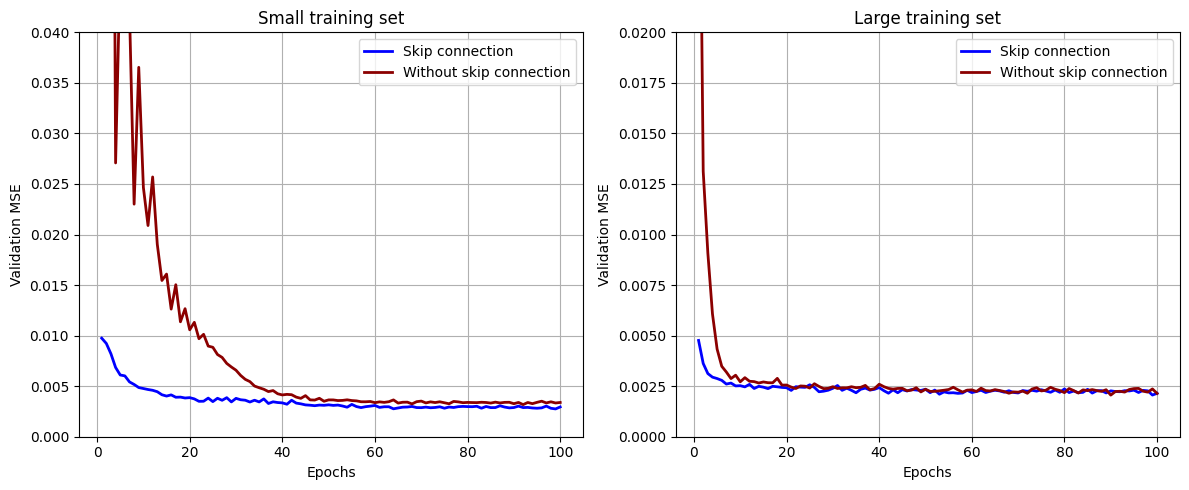

In [ ]:
epochs = range(1, len(val_loss_skip_small) + 1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot (Small training set)
axes[0].plot(epochs, val_loss_skip_small, color='blue', label='Skip connection', linewidth=2)
axes[0].plot(epochs, val_loss_wo_skip_small, color='darkred', label='Without skip connection', linewidth=2)
axes[0].set_title("Small training set")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Validation MSE")
axes[0].set_ylim([0,0.04])
axes[0].legend()
axes[0].grid(True)

# Second plot (Large training set)
axes[1].plot(epochs, val_loss_skip_large, color='blue', label='Skip connection', linewidth=2)
axes[1].plot(epochs, val_loss_wo_skip_large, color='darkred', label='Without skip connection', linewidth=2)
axes[1].set_title("Large training set")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Validation MSE")
axes[1].set_ylim([0,0.02])
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Number of layers

In [ ]:
# We implement a linear shift-invariant denoising as a one-layer neural network
net_nn_linear = CNNskipcon(depth=1, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True, non_linear=False)


train_loss_linear, val_loss_linear = train_network(net_nn_linear, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.008652210119180381 validation error:  0.008714919430203735
10 train error:  0.00603228819090873 validation error:  0.006006961106322706
20 train error:  0.0060534018848557025 validation error:  0.005949644017964602
30 train error:  0.006057281891116872 validation error:  0.006080179321579635
40 train error:  0.0061220738280098885 validation error:  0.005934364376589656
50 train error:  0.006042752764187753 validation error:  0.006036196562927216
60 train error:  0.005869296612218022 validation error:  0.0060107326414436104
70 train error:  0.006008745724102482 validation error:  0.006117361069191247
80 train error:  0.006022821355145425 validation error:  0.005982542946003378
90 train error:  0.005952043080469593 validation error:  0.005935582085512579


In [ ]:
nn_2layer= CNNskipcon(depth=2, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_2layer, val_loss_2layer = train_network(nn_2layer, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.0069017116620671 validation error:  0.006930134505964815
10 train error:  0.0043665566481649876 validation error:  0.004415317657403648
20 train error:  0.003795815078774467 validation error:  0.003854872348019853
30 train error:  0.0036378819786477834 validation error:  0.0034781851060688494
40 train error:  0.0034877792350016534 validation error:  0.0034549440699629484
50 train error:  0.0035073067992925644 validation error:  0.0035478944657370446
60 train error:  0.003529237976181321 validation error:  0.0034699675813317297
70 train error:  0.003460929525317624 validation error:  0.0034557202900759878
80 train error:  0.0034997893089894205 validation error:  0.0035747753945179284
90 train error:  0.0034115793532691896 validation error:  0.003425922071328387


In [ ]:
nn_5layer= CNNskipcon(depth=5, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_5layer, val_loss_5layer = train_network(nn_5layer, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.0052736669895239174 validation error:  0.005369097210932523
10 train error:  0.0027249821578152478 validation error:  0.002749354903353378
20 train error:  0.002594758669147268 validation error:  0.002581450252328068
30 train error:  0.002470064166118391 validation error:  0.002462545009329915
40 train error:  0.002543277063523419 validation error:  0.0025787964707706125
50 train error:  0.002475818124366924 validation error:  0.0023739939683582634
60 train error:  0.0024965745833469555 validation error:  0.0024589507351629437
70 train error:  0.002448263840051368 validation error:  0.0024791087984340266
80 train error:  0.002405836552497931 validation error:  0.0023693665117025375
90 train error:  0.0023809067643014714 validation error:  0.002398902903078124


In [ ]:
nn_10layer= CNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_10layer, val_loss_10layer = train_network(nn_10layer, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.004854802071349695 validation error:  0.004953394897747785
10 train error:  0.0024310367443831638 validation error:  0.0024189053889131173
20 train error:  0.002386482650763355 validation error:  0.002345735573908314
30 train error:  0.002292784003657289 validation error:  0.0024906007770914584
40 train error:  0.002360154001507908 validation error:  0.002241613354999572
50 train error:  0.002320764077012427 validation error:  0.0023176457185763864
60 train error:  0.0022709363256581128 validation error:  0.0021740404854062945
70 train error:  0.0022713127254974097 validation error:  0.002397483367822133
80 train error:  0.0022282647842075676 validation error:  0.00217588318628259
90 train error:  0.0022979500208748505 validation error:  0.002292736824019812


In [ ]:
nn_15layer= CNNskipcon(depth=15, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_15layer, val_loss_15layer = train_network(nn_15layer, train_loader_large, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3)

0 train error:  0.0047266002802643925 validation error:  0.00468121194280684
10 train error:  0.002532896673073992 validation error:  0.0025001570687163623
20 train error:  0.00250389936263673 validation error:  0.002338498142780736
30 train error:  0.002400704601313919 validation error:  0.002470388732617721
40 train error:  0.0022803950705565512 validation error:  0.00262725911103189
50 train error:  0.002336288962396793 validation error:  0.0022979595995275305
60 train error:  0.002315668811206706 validation error:  0.002284444741671905
70 train error:  0.0022652801999356598 validation error:  0.0021106575429439543
80 train error:  0.0022993675229372457 validation error:  0.0022673857456538826
90 train error:  0.002236171370896045 validation error:  0.0022497243189718574


In [ ]:
def conduct_tv_denoising(y_batch, lam, max_iter=200):
    """
    Solve the total variation denoising problem for a batch of 1D signals
    using a vectorized Chambolle-type algorithm.

    The optimization problem for each signal is defined as:
        min_u  0.5 * ||u - y||^2_2 + lam * TV(u)
    where TV(u) = sum(|u[i+1] - u[i]|).

    Parameters:
        y_batch (np.ndarray): Batch of noisy input signals with shape (batch_size, n).
        lam (float): Regularization parameter balancing fidelity and smoothness.
        max_iter (int): Maximum number of iterations for the algorithm.

    Returns:
        u_batch (np.ndarray): Batch of denoised signals with shape (batch_size, n).
        cost_history (list): List of average cost values over iterations.
    """
    batch_size, n = y_batch.shape
    # Initialize the dual variable for each signal (shape: (batch_size, n-1))
    p = np.zeros((batch_size, n - 1))
    tau = 0.125  # Step size parameter
    cost_history = []

    for _ in range(max_iter):
        # Compute the divergence for each signal:
        # For each signal, the divergence is defined as:
        #   div_p[:,0] = -p[:,0]
        #   div_p[:,i] = p[:,i-1] - p[:,i] for i = 1, ..., n-2
        #   div_p[:,n-1] = p[:,n-2]
        div_p = np.concatenate((
            -p[:, [0]],             # First element of divergence (shape: (batch_size, 1))
            p[:, :-1] - p[:, 1:],    # Middle elements (shape: (batch_size, n-2))
            p[:, -1:]               # Last element (shape: (batch_size, 1))
        ), axis=1)

        # Update the primal variable for each signal.
        u_batch = y_batch - lam * div_p

        # Compute the cost for each signal and store the average.
        cost_per_signal = (
            0.5 * np.sum((u_batch - y_batch) ** 2, axis=1)
            + lam * np.sum(np.abs(np.diff(u_batch, axis=1)), axis=1)
        )
        avg_cost = np.mean(cost_per_signal)
        cost_history.append(avg_cost)

        # Compute the finite difference (gradient) for each signal.
        grad_u = np.diff(u_batch, axis=1)
        # Update the dual variable with a gradient ascent step.
        p = p + tau * grad_u
        # Project p onto the l_infinity ball of radius 1.
        p = np.clip(p, -1, 1)

    return u_batch, cost_history

def eval_tv_denoising(x_gt_batch, x_denoised_batch):
    """
    Evaluate the denoising performance on a batch of signals using Mean Squared Error (MSE)
    and Peak Signal-to-Noise Ratio (PSNR).

    Parameters:
        x_gt_batch (np.ndarray): Batch of ground truth signals with shape (batch_size, n).
        x_denoised_batch (np.ndarray): Batch of denoised signals with shape (batch_size, n).

    Returns:
        mse (float): Mean squared error averaged over the batch.
        psnr (float): Average Peak Signal-to-Noise Ratio over the batch.
    """
    batch_size = x_gt_batch.shape[0]
    mse_per_signal = np.mean((x_gt_batch - x_denoised_batch) ** 2, axis=1)
    mse = np.mean(mse_per_signal)
    # Compute PSNR for each signal. Assumes that the maximum value of each ground truth signal
    # represents the dynamic range.
    psnr_per_signal = np.array([
        10 * np.log10((np.max(x_gt_batch[i]) ** 2) / mse_per_signal[i])
        if mse_per_signal[i] > 0 else float('inf')
        for i in range(batch_size)
    ])
    psnr = np.mean(psnr_per_signal)
    return mse, psnr



In [ ]:
noisy_data_list = []
for data_item in val_loader.dataset.data_list:
    # print(data_item)
    # print(get_noise(data_item, noise_std))
    noisy_data = data_item + get_noise(data_item, noise_std).data.numpy()
    noisy_data_list.append(noisy_data)
    # print(data_item.shape)

noisy_data_numpy = np.stack(noisy_data_list, axis=0)
clean_data_numpy = np.stack(val_loader.dataset.data_list, axis=0)

In [ ]:
x_denoised, cost_history = conduct_tv_denoising(noisy_data_numpy, lam=0.2, max_iter=200)

# Evaluate the performance of total-variation denoising.
mse_tv, psnr_tv = eval_tv_denoising(clean_data_numpy, x_denoised)
print("Mean Squared Error (MSE):", mse_tv)

Mean Squared Error (MSE): 0.0037191523148229285


<ipython-input-42-dc76f14f4c56>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Validation Loss', data=df, palette='muted',legend=False,hue=None)


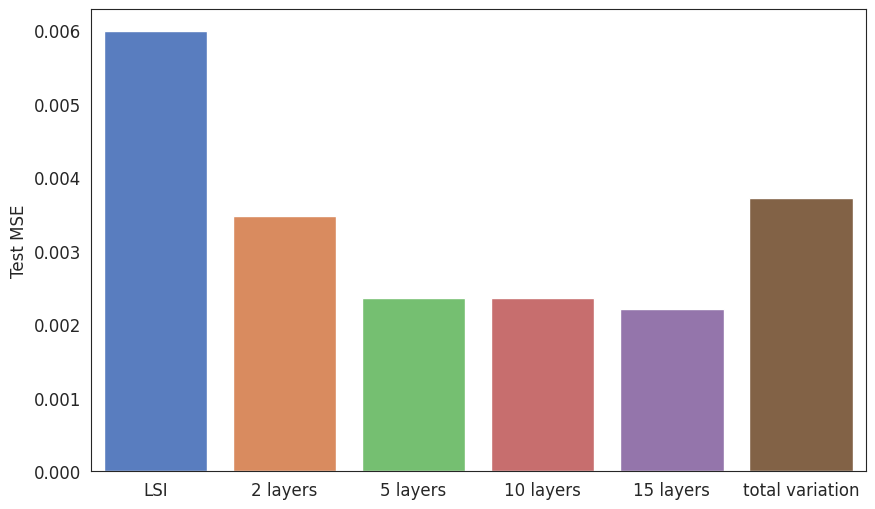

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
epoch_idx = 80
val_losses_list = [val_loss_linear[-1], val_loss_2layer[-1], val_loss_5layer[-1], val_loss_10layer[-1], val_loss_15layer[-1], mse_tv]
model_names = ['LSI', '2 layers', '5 layers', '10 layers', '15 layers', 'total variation']

# Create a DataFrame for the data
data = {
    'Model': model_names,
    'Validation Loss': val_losses_list
}

df = pd.DataFrame(data)

# Set Seaborn style to white (no grid)
sns.set_style("white")

# Create the plot
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Validation Loss', data=df, palette='muted',legend=False)

# Set plot title and labels
plt.xlabel('')
plt.ylabel('Test MSE')

# Increase font size for better visibility
plt.rcParams.update({'font.size': 12})

plt.savefig("num_layers_training_set_comparison_plot.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
